# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.29 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
# for i in range(5):                                         # play game for 5 episodes
#     env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#     states = env_info.vector_observations                  # get the current state (for each agent)
#     scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#     while True:
#         actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#         actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#         env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#         next_states = env_info.vector_observations         # get next state (for each agent)
#         rewards = env_info.rewards                         # get reward (for each agent)
#         dones = env_info.local_done                        # see if episode finished
#         scores += env_info.rewards                         # update the score (for each agent)
#         states = next_states                               # roll over states to next time step
#         if np.any(dones):                                  # exit loop if episode finished
#             break
#     print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [6]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [7]:
# Import necessary libraries
import random
import copy
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# import Agents
from ddpg_agent import Agents

In [8]:
agents = Agents(state_size=state_size, action_size=action_size, num_agents=len(env_info.agents), random_seed=5)

In [9]:
def maddpg(n_episodes=2000, max_t=1000, print_every=10):
    scores_deque = deque(maxlen=100)
    scores = []
    
    for i_episode in range(1, n_episodes+1):
#         print(i_episode)
        env_info = env.reset(train_mode=True)[brain_name] # Reset the environment
        agents.reset()                          # Reset agent noise
        states = env_info.vector_observations   # Get the current initial state for all agents
        score = np.zeros(num_agents)            # Initialize the score
        
        for t in range(max_t):
            actions = agents.act(states) 
            env_info = env.step(actions)[brain_name]    # Send the action to the environment
            next_states = env_info.vector_observations  # get the next states
            rewards = env_info.rewards                  # get the rewards
            dones = env_info.local_done                 # check if the episode has finished for any agent

            agents.step(states, actions, rewards, next_states, dones)
            
            states = next_states                        # Set next state as current state
            score += rewards                            # collect rewards into score
            if np.any(dones):
                break
                
        scores_deque.append(np.max(score))
        scores.append(np.max(score))
        
        if i_episode % print_every == 0:
            print('\rEpisode {}... Average Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
        if np.mean(scores_deque) >= 0.5:
            print('\nEnvironment solved in {:d} episodes... Average Score: {:.2f}'.format(i_episode - 100, np.mean(scores_deque)))
            torch.save(agents.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agents.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
            
    return scores

scores = maddpg()

Episode 10... Average Score: 0.01
Episode 20... Average Score: 0.00
Episode 30... Average Score: 0.00
Episode 40... Average Score: 0.00
Episode 50... Average Score: 0.00
Episode 60... Average Score: 0.00
Episode 70... Average Score: 0.00
Episode 80... Average Score: 0.00
Episode 90... Average Score: 0.00
Episode 100... Average Score: 0.00
Episode 110... Average Score: 0.00
Episode 120... Average Score: 0.00
Episode 130... Average Score: 0.01
Episode 140... Average Score: 0.02
Episode 150... Average Score: 0.02
Episode 160... Average Score: 0.02
Episode 170... Average Score: 0.02
Episode 180... Average Score: 0.02
Episode 190... Average Score: 0.02
Episode 200... Average Score: 0.02
Episode 210... Average Score: 0.02
Episode 220... Average Score: 0.02
Episode 230... Average Score: 0.02
Episode 240... Average Score: 0.00
Episode 250... Average Score: 0.00
Episode 260... Average Score: 0.00
Episode 270... Average Score: 0.01
Episode 280... Average Score: 0.01
Episode 290... Average Score:

In [10]:
# Save the actor and critic model parameters
torch.save(agents.actor_local.state_dict(), 'checkpoint_actor.pth')
torch.save(agents.critic_local.state_dict(), 'checkpoint_critic.pth')

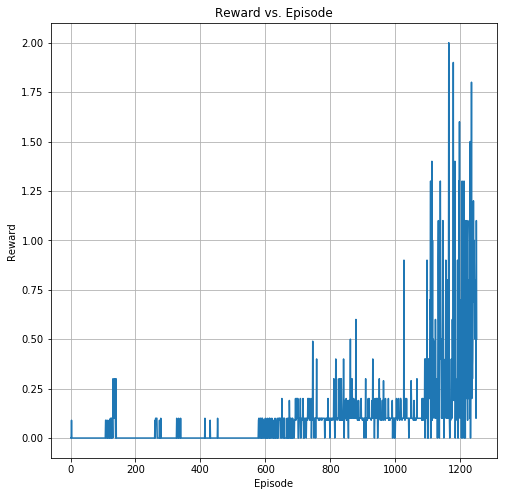

In [11]:
# Plot the scores
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.title('Reward vs. Episode')
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.grid(True)      
plt.show()

In [12]:
env.close()